In [1]:
import torch
import wandb
import sys
from condgen.data_utils.data_utils_cf_traj import SimpleTrajDataModule
from condgen.data_utils.data_utils_MNIST import MNISTDataModule
from condgen.data_utils.cv_data_utils import CVDataModule
from condgen.models.CFGAN import CFGAN
from condgen.models.baselines_cf import CFBaseline
import os
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import pytorch_lightning as pl
import pandas as pd
from skimage.metrics import structural_similarity as ssim

In [5]:
api = wandb.Api()
run = api.run("edebrouwer/counterfactuals/vyy41cno")
model_cls = CFGAN
dataset_cls = SimpleTrajDataModule
num_classes_model = 3

if model_cls == CFGAN:
    fname = [f.name for f in run.files() if (("ckpt" in f.name) and ("stage2"in f.name))][0]
else:
    fname = [f.name for f in run.files() if (("ckpt" in f.name))][0]

run.file(fname).download(replace = True, root = ".")
model = model_cls.load_from_checkpoint(fname,num_classes_model = num_classes_model,cheat_class = False)
os.remove(fname)

hparams = dict(model.hparams)
dataset = dataset_cls(**hparams)
dataset.prepare_data()
trainer = pl.Trainer(gpus=1)
preds = trainer.predict(model = model, dataloaders = dataset.test_cf_dataloader())

y_hat = [] # Predicted response
y_new = [] # New response
y_o = [] # Initial response
x = [] # X
colors = []
noise_predictions = []
T_new = []
T_o = []
for pred in preds:
    y_hat.append(pred["imgs_pred"])
    y_new.append(pred["imgs_new_true"])
    y_o.append(pred["imgs_o_true"])
    x.append(pred["imgs_x"])
    colors.append(pred["color"])
    noise_predictions.append(pred["noise_prediction"])
    T_new.append(pred["T_new"])
    T_o.append(pred["T_o"])

colors = torch.cat(colors)
noise_predictions = torch.cat(noise_predictions)
Y_hat = torch.cat(y_hat)
Y_new = torch.cat(y_new)
T_new = torch.cat(T_new)
T_o   = torch.cat(T_o)
Y_o = torch.cat(y_o)
X = torch.cat(x)

mse = (Y_hat-Y_new).pow(2).mean()
print(mse)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
/home/edward/anaconda3/envs/397/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: 0it [00:00, ?it/s]

tensor(6.4047e-05)


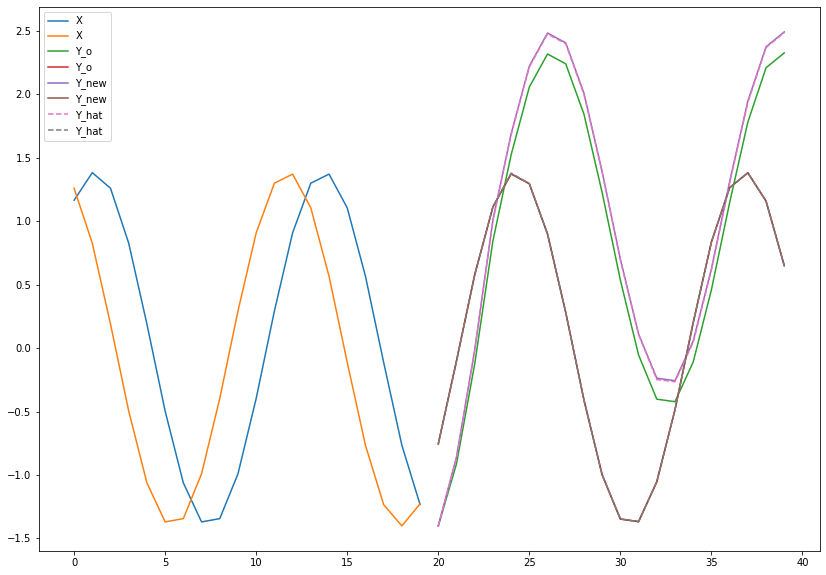

In [13]:
import matplotlib.pyplot as plt
idx = 40
x_shape = X.shape[-1]
y_shape = Y_o.shape[-1]
plt.figure(figsize = (14,10))
plt.plot(np.arange(x_shape),X[idx].T,label = "X")
plt.plot(x_shape + np.arange(y_shape),Y_o[idx].T,label = "Y_o")
plt.plot(x_shape + np.arange(y_shape),Y_new[idx].T,label = "Y_new")
plt.plot(x_shape + np.arange(y_shape),Y_hat[idx].T,label = "Y_hat", linestyle = "--")
plt.legend()
plt.show()